# Gathering of Bayesian evidence for the ELM model

In [1]:
import pickle
from pathlib import Path
import numpy as np
from periodictable import elements
from matplotlib import pyplot as plt

In [2]:
import exfor_tools
import jitr

Using database version x4i3_X4-2023-04-29 located in: /home/kyle/mambaforge/envs/om/lib/python3.10/site-packages/x4i3/data


## Let's find some data to calibrate to

Let's grab the excitation energies of the isobaric analog states from [here](https://www.sciencedirect.com/science/article/abs/pii/S0092640X97907403).

Let's grab some data from the following Exfor entries:

- [O0178](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=240178)
- [C0134](https://www-nds.iaea.org/exfor/servlet/X4sSearch5?EntryID=120134)

In [4]:
# targets to consider
# targets to consider
Ca48 = (48, 20)
Pb208 = (208, 82)
Zr90 = (90, 40)
Sn120 = (120, 50)
targets = [
    Ca48, 
    Zr90, 
    Sn120, 
    Pb208
]

In [5]:
proton = (1, 1)
neutron = (1, 0)

In [6]:
ExIAS = {}
ExIAS[Ca48] = 6.6775
ExIAS[Zr90] = 5.008
ExIAS[Sn120] = 10.204
ExIAS[Pb208] = 15.164

In [7]:
QIAS = {}
QIAS[Ca48] = 7.182
QIAS[Zr90] = 11.901
QIAS[Sn120] = 13.667
QIAS[Pb208] = 18.826

In [9]:
analogs = {}
rxn_names = {}
for isotope in targets:
    analog = (isotope[0], isotope[1] + 1)
    analogs[isotope] = analog
    name_targ = str(elements[isotope[1]].symbol)
    name_analog = str(elements[analog[1]].symbol)
    rxn_name = f"$^{{{isotope[0]}}}${name_targ}(p,n)$^{{{analog[0]}}}${name_analog}"
    rxn_names[isotope] = rxn_name

In [10]:
rxn_names

{(48, 20): '$^{48}$Ca(p,n)$^{48}$Sc',
 (90, 40): '$^{90}$Zr(p,n)$^{90}$Nb',
 (120, 50): '$^{120}$Sn(p,n)$^{120}$Sb',
 (208, 82): '$^{208}$Pb(p,n)$^{208}$Bi'}

In [11]:
db = exfor_tools.get_db()

In [83]:
entries = ["O0178"]
measurements = {}

for entry in entries:
    data_sets = db.retrieve(ENTRY=entry)[entry].getSimplifiedDataSets()
    for key, data_set in data_sets.items():
        isotope = (
            data_set.reaction[0].targ.getA(),
            data_set.reaction[0].targ.getZ(),
        )
        projectile = (
            data_set.reaction[0].proj.getA(),
            data_set.reaction[0].proj.getZ(),
        )
        quantity = data_set.reaction[0].quantity
        products = data_set.reaction[0].products
        if data_set.reaction[0].quantity == ["PAR", "DA", "EXP"]:
            subm = exfor_tools.get_measurements_from_subentry(
                [10, 200],
                data_set,
            )
    
            if isotope in measurements:
                for m in subm:
                    measurements[isotope].append(m)
            else:
                measurements[isotope] = [m for m in subm]

In [86]:
# for Anderson data at 134 and 160 MeV, the analog 0+ transition is given in two subentries
anderson134 = exfor_tools.get_measurements_from_subentry(
        [10,200],
        db.retrieve(ENTRY="C0134")["C0134"].getSimplifiedDataSets()[('C0134', 'C0134002',' ')]
)[0]

anderson160 =exfor_tools.get_measurements_from_subentry(
        [10,200],
        db.retrieve(ENTRY="C0134")["C0134"].getSimplifiedDataSets()[('C0134', 'C0134004',' ')]
)[0]

measurements[Ca48].append(anderson134)
measurements[Ca48].append(anderson160)


In [87]:
measurements[Ca48]

In [88]:
all_qepn_measurements = {}
for isotope in targets:
    all_qepn_measurements[isotope] = exfor_tools.sort_measurement_list(
        measurements[isotope]
    )

In [89]:
def plot_measurements(
    measurements,
    title,
    constant_factor=20,
    figsize=(4, 8),
    xlim=[-10, 180],
    label_offset_fraction=[0.75, 0.5],
):
    ylabel = r"$d\sigma/d\Omega$ [mb/Sr]"

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    n = 0
    for i, measurement in enumerate(measurements):
        offset = constant_factor**n
        n += 1

        # plot experiment
        x, dx, y, dy = (
            measurement.data[0, :],
            measurement.data[1, :],
            measurement.data[2, :],
            measurement.data[3, :],
        )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker=".",
            alpha=0.6,
            linestyle="none",
            color="k",
        )
        # add a label
        energy = str(measurement.Elab)
        label_loc = (
            (xlim[1] - xlim[0]) * label_offset_fraction[0],
            offset * label_offset_fraction[1],
        )
        ax.text(*label_loc, f"{energy} MeV")

    ax.set_xlim(xlim)

    # plt.ylim([1, 1e6])
    plt.title(title)
    plt.yscale("log")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\theta$ [deg]")

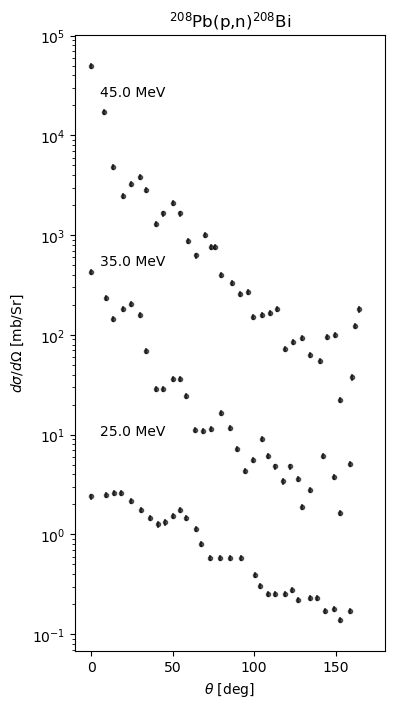

In [90]:
plot_measurements(
    all_qepn_measurements[Pb208],
    rxn_names[Pb208],
    constant_factor=50,
    label_offset_fraction=[0.03, 10],
)

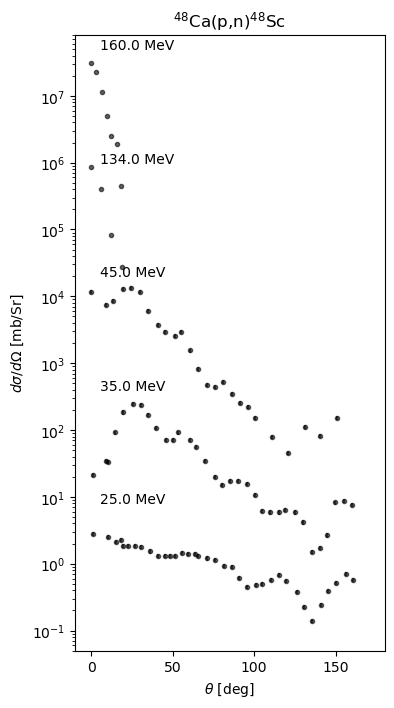

In [91]:
plot_measurements(
    all_qepn_measurements[Ca48],
    rxn_names[Ca48],
    constant_factor=50,
    label_offset_fraction=[0.03, 8],
)

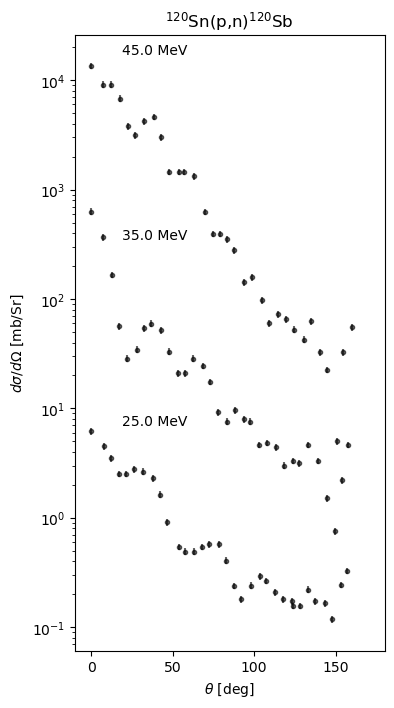

In [43]:
plot_measurements(
    all_qepn_measurements[Sn120],
    rxn_names[Sn120],
    constant_factor=50,
    label_offset_fraction=[0.1, 7],
)

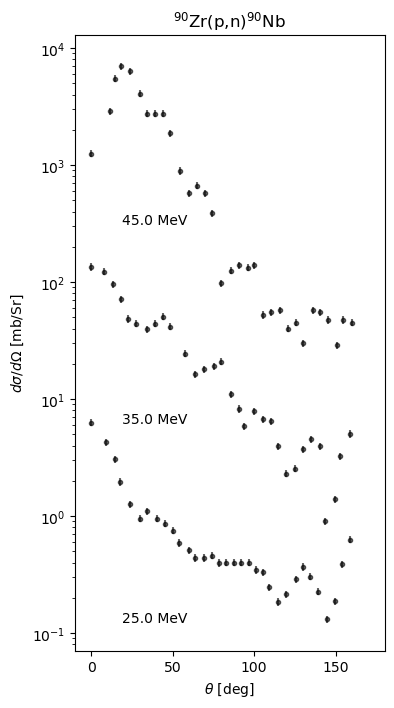

In [44]:
plot_measurements(
    all_qepn_measurements[Zr90],
    rxn_names[Zr90],
    constant_factor=50,
    label_offset_fraction=[0.1, 1 / 8],
)

## Write data to disk

In [20]:
with open("bayesian_evidence_qepn_dxsdA.pickle", "wb") as f:
    pickle.dump(all_qepn_measurements, f)

## Set up solvers for each isotope and energy
For each measurement, we will set up one solver for calibration, and one solver for visualization. These will use different angular grids.

In [21]:
core_solver = jitr.rmatrix.Solver(40)
channel_radius_fm = 20
lmax = 20
theta_vis = np.linspace(0.001, np.pi, 180)

In [22]:
def set_up_solver(target, Elab, Eias, angles_cal, angles_vis):
    analog = (target[0], target[1] + 1)
    kinp, kinn, Elab_n, Q, CDE = jitr.xs.quasielastic_pn.kinematics(
        target,
        analog,
        Elab,
        Eias,
    )
    sys = jitr.xs.quasielastic_pn.System(
        channel_radius_fm=channel_radius_fm,
        lmax=30,
        target=target,
        analog=analog,
        mass_target=jitr.utils.kinematics.mass(*target),
        mass_analog=jitr.utils.kinematics.mass(*analog),
        kp=kinp.k,
        kn=kinn.k,
    )
    workspace = jitr.xs.quasielastic_pn.Workspace(
        sys,
        kinp,
        kinn,
        Elab,
        Elab_n,
        core_solver,
        angles=angles_cal,
        tmatrix_abs_tol=1.0e-12,
    )
    workspace_vis = jitr.xs.quasielastic_pn.Workspace(
        sys,
        kinp,
        kinn,
        Elab,
        Elab_n,
        core_solver,
        angles=angles_vis,
        tmatrix_abs_tol=1.0e-12,
    )

    return workspace, workspace_vis

In [23]:
build_all_solvers = False
ws_dir = Path("./workspaces/")

if build_all_solvers:
    workspaces = {}
    for isotope in tqdm(isotopes):
        workspaces[isotope] = []

        for measurement in all_qepn_measurements[isotope]:
            theta = measurement.data[0, :] * np.pi / 180
            Elab = measurement.Elab
            workspaces[isotope].append(
                set_up_solver(isotope, Elab, ExIAS[isotope], theta, theta_vis)
            )

    for isotope in tqdm(isotopes):
        for i, measurement in enumerate(all_qepn_measurements[isotope]):
            Elab = measurement.Elab

            solver_cal, solver_vis = workspaces[isotope][i]
            solver_cal.save(
                ws_dir / f"workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )
            solver_vis.save(
                ws_dir
                / f"vis_workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )

            assert np.all(solver_cal.angles == measurement.data[0, :] * np.pi / 180)
else:
    workspaces = {}
    for isotope in tqdm(isotopes):
        workspaces[isotope] = []
        for i, measurement in enumerate(all_qepn_measurements[isotope]):
            Elab = measurement.Elab

            solver_cal = jitr.xs.quasielastic_pn.Workspace.load(
                ws_dir / f"workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )
            solver_vis = jitr.xs.quasielastic_pn.Workspace.load(
                ws_dir
                / f"vis_workspace_A_{isotope[0]}_Z_{isotope[1]}_qepn_E_{i}.pickle"
            )
            workspaces[isotope].append((solver_cal, solver_vis))

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.43it/s]


94 data points in 3 data sets


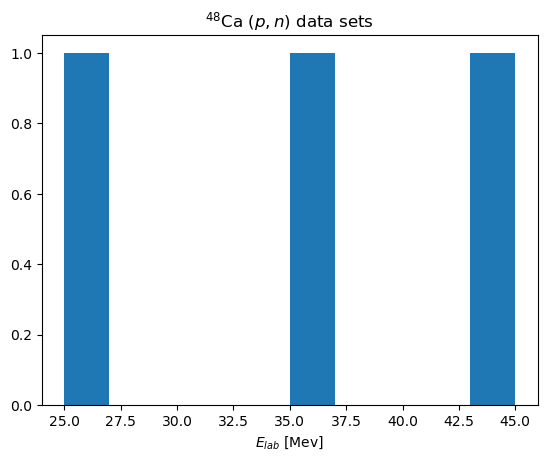

96 data points in 3 data sets


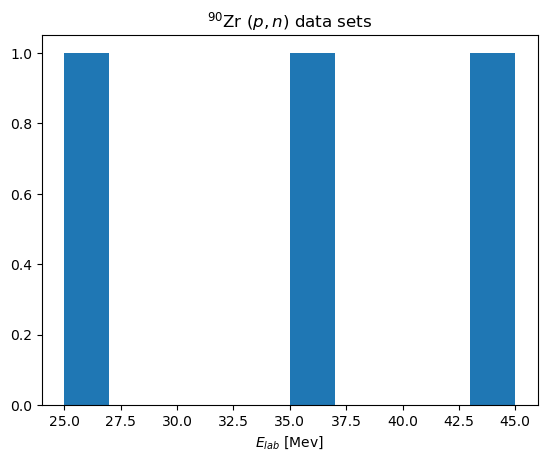

97 data points in 3 data sets


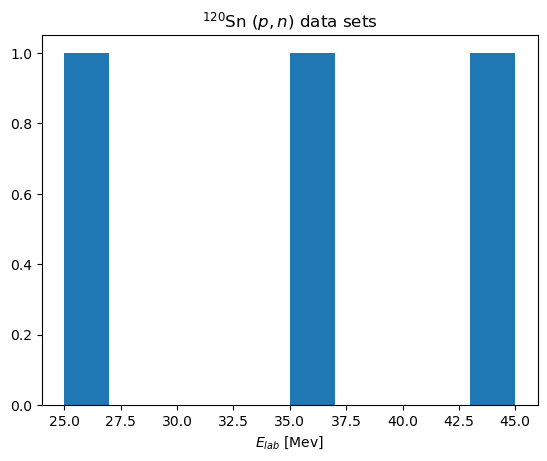

98 data points in 3 data sets


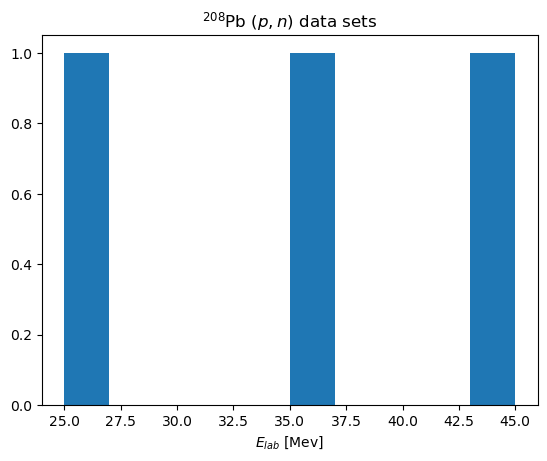

In [24]:
pn_num = 0
pn_num_meas = 0
for isotope in isotopes:
    name = str(elements[isotope[1]].symbol)

    num = np.array([m.data.shape[1] for m in all_qepn_measurements[isotope]])
    pn_num += np.sum(num)
    pn_num_meas += num.shape[0]
    print(f"{np.sum(num)} data points in {num.shape[0]} data sets")

    Ep = [m.Elab for m in all_qepn_measurements[isotope]]
    plt.hist(Ep)
    plt.title(f"$^{{{isotope[0]}}}${name} $(p,n)$ data sets")
    plt.xlabel(r"$E_{lab}$ [Mev]")
    plt.show()

In [25]:
print(f"In total {pn_num} data points in {pn_num_meas} sets for (p,n)")

In total 385 data points in 12 sets for (p,n)


## Let's load up KDUQ predictive posteriors and ELM priors and see how they compare for some of these measurements

In [26]:
# we have 416 samples from the KDUQ posterior
num_samples_kduq = 415
param_files = [
    Path(f"./KDUQFederal/{i}/parameters.json") for i in range(0, num_samples_kduq)
]
kdomps_p = [
    jitr.reactions.kduq.KDGlobal(proton, Path(param_file)) for param_file in param_files
]
kd_default_p = jitr.reactions.kduq.KDGlobal(
    proton, Path("./KDUQFederal/KD_default.json")
)
kdomps_n = [
    jitr.reactions.kduq.KDGlobal(neutron, Path(param_file))
    for param_file in param_files
]
kd_default_n = jitr.reactions.kduq.KDGlobal(
    neutron, Path("./KDUQFederal/KD_default.json")
)

In [27]:
def run_kd_uq(solver, omp_n, omp_p, num_samples=50, model_err=0, inner_pctls=[50, 90]):
    # get a differential xs for each parameter sample
    xs = np.zeros((len(solver.angles), num_samples))
    idxs = np.random.choice(len(omp_n), size=num_samples)
    inner_pctls = np.array(inner_pctls)
    pctls = np.hstack((50 - inner_pctls[::-1] / 2, 50 + inner_pctls / 2))

    for j, idx in enumerate(idxs):
        kinp = solver.kinematics_entrance
        kinn = solver.kinematics_exit
        nom = omp_n[idx]
        pom = omp_p[idx]

        coul_p, scalar_params_p, spin_orbit_params_p = pom.get_params(
            *solver.sys.target, kinp.mu, solver.Elab_entrance, kinp.k
        )
        coul_n, scalar_params_n, spin_orbit_params_n = nom.get_params(
            *solver.sys.analog, kinn.mu, solver.Elab_exit, kinn.k
        )
        xs_sample = solver.xs(
            jitr.reactions.coulomb_charged_sphere,
            jitr.reactions.KD_scalar,
            jitr.reactions.KD_spin_orbit,
            jitr.reactions.KD_scalar,
            jitr.reactions.KD_spin_orbit,
            args_p_coulomb=coul_p,
            args_p_scalar=scalar_params_p,
            args_p_spin_orbit=spin_orbit_params_p,
            args_n_scalar=scalar_params_n,
            args_n_spin_orbit=spin_orbit_params_n,
        )
        xs[:, j] = xs_sample + np.random.normal(
            0, model_err * xs_sample, size=(len(solver.angles))
        )

        interval_boundaries = [
            boundary for boundary in np.percentile(xs, pctls, axis=1)
        ]

    return (solver.angles, *interval_boundaries)


def run_full_uq_kd(
    kduq_omps_n, kduq_omps_p, num_samples, model_err=0, inner_pctls=[50, 90]
):
    kd_intervals = {}
    for isotope in tqdm(isotopes):
        print(f"Running UQ for {isotope}")
        kd_intervals[isotope] = []

        for i, measurement in enumerate(all_qepn_measurements[isotope]):
            kd_intervals[isotope].append(
                run_kd_uq(
                    workspaces[isotope][i][1],
                    kduq_omps_n,
                    kduq_omps_p,
                    num_samples=num_samples,
                    model_err=model_err,
                    inner_pctls=inner_pctls,
                )
            )
    return kd_intervals

In [28]:
kduq_pred_post_qepn = run_full_uq_kd(kdomps_n, kdomps_p, 300)

  0%|                                                                         | 0/4 [00:00<?, ?it/s]

Running UQ for (48, 20)


/home/beyerk/Projects/jitr/src/jitr/reactions/kduq.py:267: RuntimeWarning: overflow encountered in exp
  d2 = self.d2_0 + self.d2_A / (1 + np.exp((A - self.d2_A3) / self.d2_A2))
 25%|████████████████▎                                                | 1/4 [00:15<00:45, 15.33s/it]

Running UQ for (90, 40)


 50%|████████████████████████████████▌                                | 2/4 [00:25<00:25, 12.52s/it]

Running UQ for (120, 50)


 75%|████████████████████████████████████████████████▊                | 3/4 [00:36<00:11, 11.56s/it]

Running UQ for (208, 82)


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.63s/it]


In [30]:
with open("kduq_pred_post_qepn.pickle", "wb") as f:
    pickle.dump(kduq_pred_post_qepn, f)

In [31]:
from elm import *

In [32]:
def run_elm_uq(
    solver, Elab, samples, num_samples=50, model_err=0, inner_pctls=[50, 90]
):
    # get a differential xs for each parameter sample
    xs = np.zeros((len(solver.angles), num_samples))
    idxs = np.random.choice(len(samples), size=num_samples)
    inner_pctls = np.array(inner_pctls)
    pctls = np.hstack((50 - inner_pctls[::-1] / 2, 50 + inner_pctls / 2))

    for j, idx in enumerate(idxs):
        # neutron calculation
        elm_params = samples[idx]
        pscalar, pvector, pso, coul, target_alpha = el_model_params(
            proton, *solver.sys.target, solver.kinematics_entrance.Ecm, elm_params
        )
        nscalar, nvector, nso, _, analog_alpha = el_model_params(
            neutron, *solver.sys.analog, solver.kinematics_exit.Ecm, elm_params
        )

        xs_sample = solver.xs(
            jitr.reactions.coulomb_charged_sphere,
            elm_spin_scalar,
            elm_so,
            elm_spin_scalar,
            elm_so,
            args_p_coulomb=coul,
            args_p_scalar=(proton, target_alpha, pscalar, pvector),
            args_p_spin_orbit=pso,
            args_n_scalar=(neutron, analog_alpha, nscalar, nvector),
            args_n_spin_orbit=nso,
        )

        xs[:, j] = xs_sample + np.random.normal(
            0, model_err * xs_sample, size=(len(solver.angles))
        )

        interval_boundaries = [
            boundary for boundary in np.percentile(xs, pctls, axis=1)
        ]

    return (solver.angles, *interval_boundaries)


def run_full_uq_elm(samples, num_samples, model_err=0, inner_pctls=[50, 90]):
    elm_intervals = {}
    for isotope in tqdm(isotopes):
        print(f"Running UQ for {isotope}")
        elm_intervals[isotope] = []

        for i, measurement in enumerate(all_qepn_measurements[isotope]):
            Elab = measurement.Elab

            elm_intervals[isotope].append(
                run_elm_uq(
                    workspaces[isotope][i][1],
                    Elab,
                    samples,
                    num_samples=num_samples,
                    model_err=model_err,
                    inner_pctls=inner_pctls,
                )
            )
    return elm_intervals

In [33]:
elm_prior_samples = np.load("prior_samples.npy")

In [34]:
elm_pred_prior_qepn = run_full_uq_elm(elm_prior_samples, 300)

  0%|                                                                         | 0/4 [00:00<?, ?it/s]

Running UQ for (48, 20)


 25%|████████████████▎                                                | 1/4 [00:11<00:33, 11.18s/it]

Running UQ for (90, 40)


 50%|████████████████████████████████▌                                | 2/4 [00:21<00:21, 10.93s/it]

Running UQ for (120, 50)


 75%|████████████████████████████████████████████████▊                | 3/4 [00:32<00:10, 10.82s/it]

Running UQ for (208, 82)


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:42<00:00, 10.73s/it]


In [35]:
def plot_measurements_and_intervals(
    measurements,
    title,
    model_intervals,
    color,
    label,
    constant_factor=20,
    figsize=(4, 8),
    xlim=[-10, 180],
    label_offset_fraction=[0.75, 0.5],
):
    ylabel = r"$d\sigma/d\Omega$ [mb/Sr]"

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    n = 0
    for i, measurement in enumerate(measurements):
        offset = constant_factor**n
        n += 1

        # plot experiment
        x, dx, y, dy = (
            measurement.data[0, :],
            measurement.data[1, :],
            measurement.data[2, :],
            measurement.data[3, :],
        )
        ax.errorbar(
            x,
            offset * y,
            offset * dy,
            marker=".",
            alpha=0.6,
            linestyle="none",
            color="k",
        )

        ax.fill_between(
            model_intervals[i][0] * 180 / np.pi,
            model_intervals[i][1] * offset,  # 50% CI
            model_intervals[i][-1] * offset,
            color=color,
            alpha=0.5,
        )
        # add a label
        energy = str(measurement.Elab)
        label_loc = (
            (xlim[1] - xlim[0]) * label_offset_fraction[0],
            offset * label_offset_fraction[1],
        )
        ax.text(*label_loc, f"{energy} MeV")

    leg_models = [Line2D([0], [0], color=color, label=label)]
    ax.legend(handles=leg_models, loc="upper right")

    ax.set_xlim(xlim)

    # plt.ylim([1, 1e6])
    plt.title(title)
    plt.yscale("log")
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r"$\theta$ [deg]")

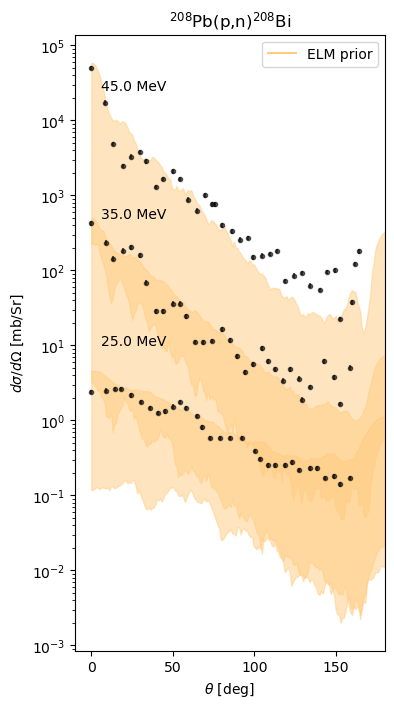

In [36]:
plot_measurements_and_intervals(
    all_qepn_measurements[Pb208],
    rxn_names[Pb208],
    elm_pred_prior_qepn[Pb208],
    elm_color,
    "ELM prior",
    constant_factor=50,
    label_offset_fraction=[0.03, 10],
)

(0.01, 100000.0)

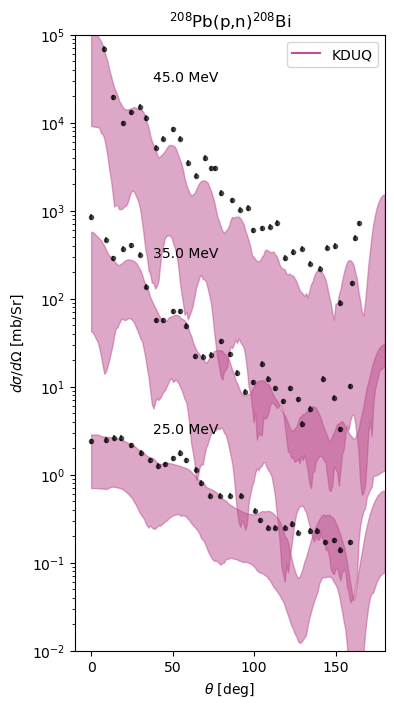

In [37]:
plot_measurements_and_intervals(
    all_qepn_measurements[Pb208],
    rxn_names[Pb208],
    kduq_pred_post_qepn[Pb208],
    kd_color,
    "KDUQ",
    constant_factor=100,
    label_offset_fraction=[0.2, 3],
)
plt.ylim([1e-2, 1e5])

In [38]:
def plot_single_sample(solver, params, measurement):
    fig, ax = plt.subplots(
        1,
        1,
    )
    # plot experiment
    x, dx, y, dy = (
        measurement.data[0, :],
        measurement.data[1, :],
        measurement.data[2, :],
        measurement.data[3, :],
    )
    ax.errorbar(
        x,
        y,
        dy,
        marker=".",
        alpha=0.6,
        linestyle="none",
        color="k",
    )

    for p in params:
        pscalar, pvector, pso, coul, target_alpha = el_model_params(
            proton, *solver.sys.target, solver.kinematics_entrance.Ecm, p
        )
        nscalar, nvector, nso, _, analog_alpha = el_model_params(
            neutron, *solver.sys.analog, solver.kinematics_exit.Ecm, p
        )

        xs_sample = solver.xs(
            jitr.reactions.coulomb_charged_sphere,
            elm_spin_scalar,
            elm_so,
            elm_spin_scalar,
            elm_so,
            args_p_coulomb=coul,
            args_p_scalar=(proton, target_alpha, pscalar, pvector),
            args_p_spin_orbit=pso,
            args_n_scalar=(neutron, analog_alpha, nscalar, nvector),
            args_n_spin_orbit=nso,
        )

        plt.plot(solver.angles * 180 / np.pi, xs_sample)
    plt.xlabel(r"$\theta$ [deg]")
    plt.ylabel("$d\sigma / d\Omega$")
    plt.yscale("log")